In [1]:
import numpy as np
import tensorflow as tf
import os

In [2]:
no_groups = len(os.listdir(r'D:\Birds\birdsdata\train'))
no_groups

450

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(7)
tr_dir = r'D:\Birds\birdsdata\train'
te_dir = r'D:\Birds\birdsdata\test'
va_dir = r'D:\Birds\birdsdata\valid'


train_datagen = ImageDataGenerator(rescale=1/255.,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1/255.,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_dataset = train_datagen.flow_from_directory(tr_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode='categorical')

test_dataset = test_datagen.flow_from_directory(te_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode='categorical')

val_dataset = val_datagen.flow_from_directory(va_dir,
                                           batch_size=32,
                                           target_size=(224, 224),
                                           class_mode='categorical')

Found 70626 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.
Found 2250 images belonging to 450 classes.


In [4]:
model = tf.keras.applications.InceptionV3(include_top=False)

model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='InputLayer')

new = model(inputs)

new = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(new)

outputs = tf.keras.layers.Dense(no_groups, activation='softmax', name='OutputLayer')(new)

model_ver1 = tf.keras.Model(inputs, outputs)

model_ver1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
history_ver1 = model_ver1.fit(train_dataset,
                       epochs=10,
                       steps_per_epoch=len(train_dataset),
                       validation_data=val_dataset,
                       validation_steps=int(0.25*len(val_dataset)))

Epoch 1/10
2208/2208 [==============================] - 2507s 1s/step - loss: 1.7899 - accuracy: 0.5836 - val_loss: 0.9618 - val_accuracy: 0.7243
Epoch 2/10
2208/2208 [==============================] - 1365s 618ms/step - loss: 1.0231 - accuracy: 0.7413 - val_loss: 0.7653 - val_accuracy: 0.7904
Epoch 3/10
2208/2208 [==============================] - 1368s 620ms/step - loss: 0.8640 - accuracy: 0.7793 - val_loss: 0.7006 - val_accuracy: 0.7996
Epoch 4/10
2208/2208 [==============================] - 1382s 626ms/step - loss: 0.7521 - accuracy: 0.8065 - val_loss: 0.6513 - val_accuracy: 0.8327
Epoch 5/10
2208/2208 [==============================] - 1408s 638ms/step - loss: 0.6814 - accuracy: 0.8241 - val_loss: 0.5681 - val_accuracy: 0.8309
Epoch 6/10
2208/2208 [==============================] - 1413s 640ms/step - loss: 0.6351 - accuracy: 0.8358 - val_loss: 0.5845 - val_accuracy: 0.8346
Epoch 7/10
2208/2208 [==============================] - 1382s 626ms/step - loss: 0.5788 - accuracy: 0.8467 - 

In [9]:
model_ver1.save('modelbefore.h5')

In [6]:
results_ver1 = model_ver1.evaluate(test_dataset)
results_ver1

71/71 [==============================] - 58s 823ms/step - loss: 0.5656 - accuracy: 0.8716


[0.5656266808509827, 0.8715555667877197]

In [7]:
model_ver1.trainable = True

for layer in model_ver1.layers[:-10]:
  layer.trainable = False

model_ver1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [8]:
model_ver1.save('model1.h5')

In [10]:
initial_epochs = 10
history_fine_tuned = model_ver1.fit(train_dataset,
                                 epochs=15,
                                 validation_data=val_dataset,
                                 validation_steps=int(0.25 * len(val_dataset)),
                                 initial_epoch=history_ver1.epoch[-1])

Epoch 10/15
2208/2208 [==============================] - 5207s 2s/step - loss: 0.5284 - accuracy: 0.8596 - val_loss: 0.2751 - val_accuracy: 0.9191
Epoch 11/15
2208/2208 [==============================] - 5191s 2s/step - loss: 0.2650 - accuracy: 0.9248 - val_loss: 0.2429 - val_accuracy: 0.9320
Epoch 12/15
2208/2208 [==============================] - 5154s 2s/step - loss: 0.2042 - accuracy: 0.9405 - val_loss: 0.2446 - val_accuracy: 0.9283
Epoch 13/15
2208/2208 [==============================] - 5068s 2s/step - loss: 0.1607 - accuracy: 0.9518 - val_loss: 0.2703 - val_accuracy: 0.9283
Epoch 14/15
2208/2208 [==============================] - 5438s 2s/step - loss: 0.1391 - accuracy: 0.9577 - val_loss: 0.1534 - val_accuracy: 0.9504
Epoch 15/15
2208/2208 [==============================] - 5200s 2s/step - loss: 0.1156 - accuracy: 0.9639 - val_loss: 0.1821 - val_accuracy: 0.9522


In [11]:
results_ver2 = model_ver1.evaluate(test_dataset)
results_ver2

71/71 [==============================] - 59s 825ms/step - loss: 0.1100 - accuracy: 0.9724


[0.10995027422904968, 0.9724444150924683]

In [12]:
model_ver1.save('finetunedfinal.h5')

In [8]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Image Tensor Of Shape (img_shape, img_shape, 3)
  """
  # Read In The Image 
  img = tf.io.read_file(filename)

  # Decode Image Into Tensor
  img = tf.io.decode_image(img, channels=3)

  # Resizing The Image
  img = tf.image.resize(img, [img_shape, img_shape])

  # scale? Yes/No
  if scale:
    return img/255.
  else:
    return img

In [9]:
import numpy as np
import pathlib
data_dir = pathlib.Path(r'D:\Birds\birdsdata\train')
classnames = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(classnames)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'ALBATROSS'
 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN FLAMINGO' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'AUCKLAND SHAQ' 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT'
 'AZARAS SPINETAIL' 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER'
 'AZURE TIT' 'BAIKAL TEAL' 'BALD EAGLE' 'BALD IBIS' 'BALI STARLING'
 'BALTIMORE ORIOLE' 'BANANAQUIT' 'BAND TAILED GUAN' 'BANDED BROADBILL'
 'BAN

In [10]:
import matplotlib.pyplot as plt
def pred_and_plot(model, filename, class_names=classnames):
  
  """
  """

  img = load_and_prep_image(filename)

  pred = new_model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = classnames[tf.argmax(pred[0])]
  else:
    pred_class = classnames[int(tf.round(pred[0]))]


  plt.imshow(img)
  plt.title(f'PREDICTION: {pred_class}')
  plt.axis(False);

In [6]:
import tensorflow as tf
load_and_prep_image(r"D:\Birds\birdsdata\test\ABYSSINIAN GROUND HORNBILL\2.jpg",224,True)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.43137255, 0.4509804 , 0.19215687],
        [0.43529412, 0.45490196, 0.19607843],
        [0.4392157 , 0.45882353, 0.19607843],
        ...,
        [0.6039216 , 0.6392157 , 0.27450982],
        [0.6       , 0.63529414, 0.27058825],
        [0.59607846, 0.6313726 , 0.26666668]],

       [[0.44313726, 0.4627451 , 0.20392157],
        [0.44705883, 0.46666667, 0.20784314],
        [0.4509804 , 0.47058824, 0.20784314],
        ...,
        [0.6039216 , 0.6392157 , 0.27450982],
        [0.59607846, 0.6313726 , 0.26666668],
        [0.5921569 , 0.627451  , 0.2627451 ]],

       [[0.44705883, 0.46666667, 0.20392157],
        [0.45882353, 0.47843137, 0.21568628],
        [0.45882353, 0.47843137, 0.21568628],
        ...,
        [0.61960787, 0.64705884, 0.28235295],
        [0.6039216 , 0.6392157 , 0.27450982],
        [0.6039216 , 0.6392157 , 0.27450982]],

       ...,

       [[0.36078432, 0.35686275, 0.3764706 ],
        [0.39

In [11]:
import tensorflow as tf
new_model=tf.keras.models.load_model('finetunedfinal.h5')
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 GlobalAveragePoolingLayer (  (None, 2048)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 OutputLayer (Dense)         (None, 450)               922050    
                                                                 
Total params: 22,724,834
Trainable params: 22,690,402
Non-trainable params: 34,432
_________________________________________________________________


In [10]:
filename = "test_birdsfinal.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tf_lite_converter.convert()
open(filename, "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\risal\AppData\Local\Temp\tmp53tr776j\assets


INFO:tensorflow:Assets written to: C:\Users\risal\AppData\Local\Temp\tmp53tr776j\assets


90818944

1/1 [==============================] - 2s 2s/step


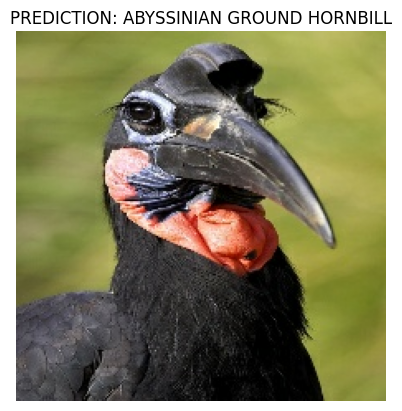

In [12]:
pred_and_plot(new_model, filename=r"D:\Birds\birdsdata\test\ABYSSINIAN GROUND HORNBILL\2.jpg")